# March Madness Predictor
## By: Joe Opitz
### CSCI 447 - Machine Learning Project
#### Complete Notebook
##### Data Preprocessing & Visualization (see Data Preprocessing Notebook for more in depth, only most important stuff included)

Import the necessary libraries

In [1]:
# Data Manipulation libraries
import pandas as pd
import numpy as np
# Data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
# sklearn models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
# accuracy metrics
from sklearn.metrics import accuracy_score, classification_report
# tensorflow neural network libraries
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
'''

'\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, Dropout\nfrom tensorflow.keras.regularizers import l2\n'

Download all of the datasets and make them dataframes

In [2]:
ratings = pd.read_csv('data/538 ratings.csv')
bart_away = pd.read_csv('data/Barttorvik Away.csv')
bart_AN = pd.read_csv('data/Barttorvik Away-Neutral.csv')
bart_home = pd.read_csv('data/Barttorvik Home.csv')
bart_neut = pd.read_csv('data/Barttorvik Neutral.csv')
coach = pd.read_csv('data/Coach Results.csv')
conf_res = pd.read_csv('data/Conference Results.csv')
conf_stat = pd.read_csv('data/Conference Stats.csv')
heat_check = pd.read_csv('data/Heat Check Tournament Index.csv')
KenBart = pd.read_csv('data/KenPom Barttorvik.csv')
pre_votes = pd.read_csv('data/Preseason Votes.csv')
pub_picks = pd.read_csv('data/Public Picks.csv')
resume = pd.read_csv('data/Resumes.csv')
seed = pd.read_csv('data/Seed Results.csv')
shoot_split = pd.read_csv('data/Shooting Splits.csv')
team_res = pd.read_csv('data/Team Results.csv')
tourn_locations = pd.read_csv('data/Tournament Locations.csv')
tourn_matchups = pd.read_csv('data/Tournament Matchups.csv')
upset_count = pd.read_csv('data/Upset Count.csv')
upset_seed_info = pd.read_csv('data/Upset Seed Info.csv')

Create seperate functions to grab & drop specific year.  
Not very useful anymore, more was just used to help gather data for training data.

In [3]:
def DropYear(df,year):
    return df[df['YEAR'] != year]

def GrabSpecificYear(df,year):
    return df[df['YEAR'] == year]

Create a function that can merge specifically chosen features from the dataset, as well as selecting specific features from a specific df

In [4]:
# Keys represents what column you would like to merge the dataframes on
# dfs is an array of dataframes that you will use to create an inputs dataframe
# Exclude the year that you are making the model for
def MergeInputs(df1, df2, keys):
    df = pd.merge(df1,df2,on=keys, how='left')
    return df
    
# Creates individual dataframes of selected features
def SelectFeatures(df, features):
    # Select the specified features from the DataFrame
    # Could use df[features] directly, but this handles cases where some features might not exist in the DataFrame
    temp_df = df[[feature for feature in features if feature in df.columns]]
    
    # Return all years minus the year the model is being made for
    return temp_df

Select features from dataset

In [5]:
# Features that I thought were important
# As well as found to improve accuracy through trial and error
features = ['YEAR','TEAM','SEED','CURRENT ROUND','EXP','ELITE SOS','KADJ EM','WIN%','BARTHAG','ELO', 
            'TALENT', 'NET RPI', 'BADJ EM', 'KADJ O', 'KADJ D']

# How dataframes should be be merged together
# Variable holder to make merging dataframes easier.
key = ['YEAR', 'TEAM']

# Grab features from any dataset that you want and merge them together into a datafrane
# If want data from more sources, just create more variables and steps. May be worth trying
# to automate this eventually once not on a time crunch for future years.
ken_df = SelectFeatures(KenBart, features)
resume_df = SelectFeatures(resume, features)
inputs_df = MergeInputs(ken_df, resume_df, key)

In [6]:
inputs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1079 entries, 0 to 1078
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   YEAR       1079 non-null   int64  
 1   TEAM       1079 non-null   object 
 2   SEED_x     1079 non-null   int64  
 3   EXP        1079 non-null   float64
 4   ELITE SOS  1079 non-null   float64
 5   KADJ EM    1079 non-null   float64
 6   WIN%       1079 non-null   float64
 7   BARTHAG    1079 non-null   float64
 8   TALENT     1079 non-null   float64
 9   BADJ EM    1079 non-null   float64
 10  KADJ O     1079 non-null   float64
 11  KADJ D     1079 non-null   float64
 12  SEED_y     1079 non-null   int64  
 13  ELO        1079 non-null   int64  
 14  NET RPI    1079 non-null   int64  
dtypes: float64(9), int64(5), object(1)
memory usage: 134.9+ KB


Function to combine input data with matchup data to allow for predictions to be made

In [7]:
def combine(df1, df2, key):
    #predictor_df = DropYear(df1, 2024)
    df = pd.merge(df1, df2, on=key, how='left', suffixes=('','_dup'))
    df = df[df.columns.drop(list(df.filter(regex='_dup')))]
    return df.drop(['BY YEAR NO', 'BY ROUND NO', 'TEAM NO'], axis=1).reset_index()
df = combine(tourn_matchups, inputs_df, ['YEAR', 'TEAM'])

### These cells are not useful for final run through, just how I split up train and test splits

years = [2017,  2023]

test_set_years = df['YEAR'].isin(years)

test = df[test_set_years]

X_test = test[features]

Create a training set, will be what I build my model off of.

years = [2008,2009,2010,2011,2012,2013,2014,
        2015,2016,2018,2019,2021,2022]

train_set_years = df['YEAR'].isin(years)

train = df[train_set_years]

Create a correlation plot view how attributes impact how deep a team can go, helps with figuring out feature importance

C:\Users\jopitz\AppData\Local\Temp\ipykernel_10912\12239556.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(abs(df.corr())[['ROUND']].sort_values(by='ROUND', ascending=False), vmin=0,vmax=1,


<Axes: title={'center': 'Features Correlating with Round'}>

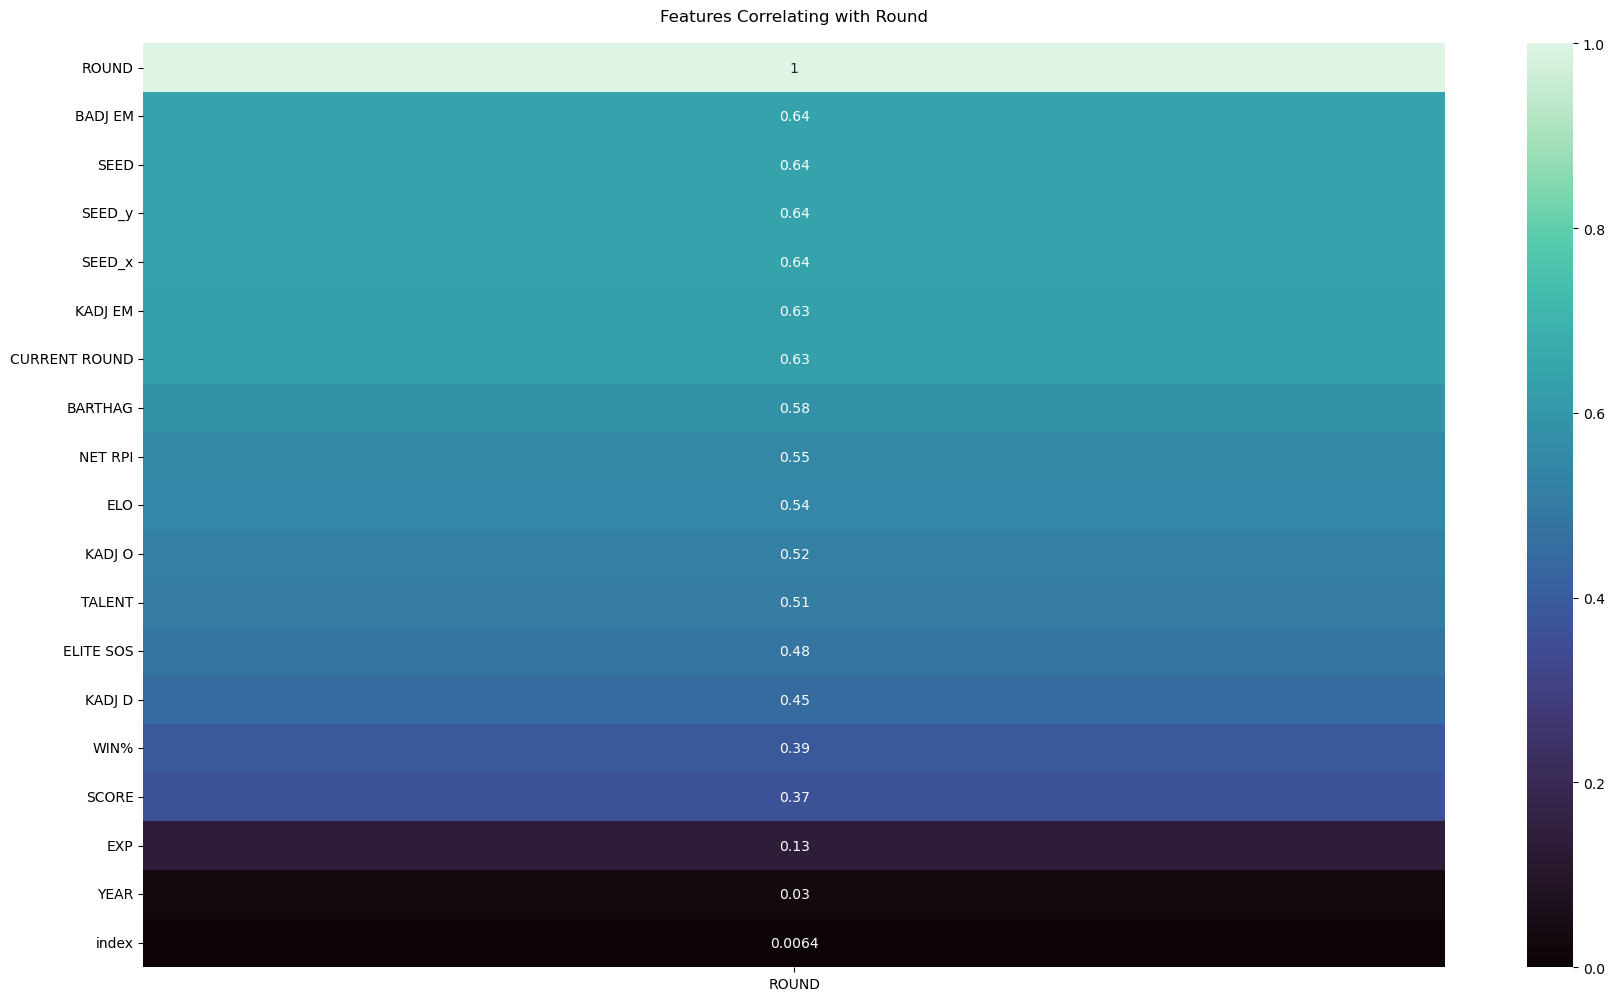

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(21,12))
heatmap = sns.heatmap(abs(df.corr())[['ROUND']].sort_values(by='ROUND', ascending=False), vmin=0,vmax=1,
                      annot=True, cmap='mako')
heatmap.set_title('Features Correlating with Round', fontdict={'fontsize':12}, pad=16);
heatmap

##### Tested models (See model-testing notebook for actual results. One thing to note is that I re-added in Decision Trees and removed Neural Network.)
Was unable to get any neural nets to work very well. Something to think about for the future when you are a bit more experienced, and are able to use them at an effective rate. But still difficult to use with the sizes of my datasets.
##### Lookk at each of the models individual notebooks to view how the models were fine-tuned. Below are the 5 best model. None are miles better then the rest, so not in any particular order. Fine-tuning hasn't done much, may be worth to try to keep improving if you believe that they need work. Need to make sure that 2024 data will be very easy to implement.
-Naive Bayes  
-Random Forest  
-Support Vector Classifier  
-Logistic Regression  
-Decision Tree  

First will need to convert a dataframe to where I can predict game-by-game. Needed for the tournament simulation to run correctly. It also allows for you to, in a way, double the size of your data set. It does this by setting the matchups up as TEAM_A and TEAM_B and then swaps them and the difference between features (mult. by -1) of the datasets. Allows for each game to be of use twice.

#### Prepare tournament matchups for training.

In [9]:
def prepare_matchups(data, features):
    """
    Transforms the original dataset into a format with comparative features for matchups.
    
    Args:
    - data: The dataset to transform.
    - features: A list of feature names to use in comparison.
    
    Returns:
    - A DataFrame with comparative features and the target variable for each matchup.
    """
    # Create a temporary dataframe
    matchups = pd.DataFrame()
    # Grabs each the difference between each feature, except for CURRENT ROUND and TEAM
    for feature in features:
        matchups['TEAM_A'] = data['TEAM'][::2].values
        matchups['TEAM_B'] = data['TEAM'][1::2].values
        matchups['YEAR'] = data['YEAR'][::2].values
        matchups['CURRENT ROUND'] = data['CURRENT ROUND'][::2].values
        if feature != 'TEAM' and feature != 'CURRENT ROUND':
            matchups[f'{feature}'] = data[feature][::2].values - data[feature][1::2].values
        else:
            matchups['TEAM_A'] = data[feature][::2].values
            matchups['TEAM_B'] = data[features][1::2].values
    
    matchups['SCORE_DIFF'] = data['SCORE'][::2].values - data['SCORE'][1::2].values
    
    return matchups

# List of features to compare, # KADJ O and D not apart of final dataset, just trying something
numerical_features = ['SEED','CURRENT ROUND','EXP','ELITE SOS','KADJ EM','WIN%','BARTHAG','ELO', 
            'TALENT', 'NET RPI', 'BADJ EM', 'KADJ O', 'KADJ D']
matchup_df = prepare_matchups(df, numerical_features)


In [10]:
def nans(df): return df[df.isnull().any(axis=1)]

In [11]:
nans(matchup_df)

,TEAM_A,TEAM_B,YEAR,CURRENT ROUND,SEED,EXP,ELITE SOS,KADJ EM,WIN%,BARTHAG,ELO,TALENT,NET RPI,BADJ EM,KADJ O,KADJ D,SCORE_DIFF
0,Connecticut,Stetson,2024,64,-15,-0.349,20.981,36.31710,29.886148,0.615,-156,38.477,-207,39.218,16.346,-19.9711,NaN
1,Florida Atlantic,Northwestern,2024,64,-1,0.458,-10.433,0.33020,10.132576,-0.056,-17,-13.964,-14,-3.714,2.304,1.9730,NaN
2,San Diego St.,UAB,2024,64,-7,0.290,12.628,13.41751,2.083333,0.216,-33,21.680,-85,11.223,-0.132,-13.5488,NaN
3,Auburn,Yale,2024,64,-9,0.285,11.838,19.42985,10.446247,0.213,-48,33.957,-78,18.873,9.754,-9.6755,NaN
4,BYU,Duquesne,2024,64,-5,0.233,11.228,11.63806,2.049911,0.146,-3,19.283,-69,11.477,13.565,1.9268,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,North Carolina,Saint Mary's,2024,16,-4,0.245,11.093,4.75740,1.286765,0.011,-5,49.695,-8,1.451,2.895,-1.8622,NaN
66,Houston,Duke,2024,16,-3,1.128,7.517,6.84210,13.235294,0.052,-18,-28.067,-8,9.729,-2.959,-9.8010,NaN
67,Houston,Wisconsin,2024,16,-4,0.306,-2.668,11.11850,25.378151,0.077,-43,11.349,-17,12.669,-1.192,-12.3110,NaN
68,Purdue,Kansas,2024,16,-3,-0.238,-1.187,9.89270,20.136852,0.053,-41,-11.624,-18,10.660,11.606,1.7134,NaN


In [12]:
test_df = matchup_df[matchup_df['YEAR'] != 2024]

years = [2017,  2023]

test_set_years = matchup_df['YEAR'].isin(years)

test = matchup_df[test_set_years]

test

years = [2008,2009,2010,2011,2012,2013,2014,
        2015,2016,2018,2019,2021,2022]

train_set_years = matchup_df['YEAR'].isin(years)

train = matchup_df[train_set_years]

X_train = train[numerical_features]
y_train = train['SCORE_DIFF']

##### Set up the datasets to be in a usable form. Allows for first-round matchups to be inputted into my tournament simulation below and make predictions. As well as training sets.

In [13]:
df_train = DropYear(matchup_df, 2024)
df_2024 = GrabYear(df, 2024)
X_train = df_train[numerical_features]
y_train = (df_train['SCORE_DIFF'] > 0).astype(int)
df_2024 = df_2024[df_2024['CURRENT ROUND'] == 64]
final_run = df_2024[numerical_features]

In [14]:
df_train.head(30)

,TEAM_A,TEAM_B,YEAR,CURRENT ROUND,SEED,EXP,ELITE SOS,KADJ EM,WIN%,BARTHAG,ELO,TALENT,NET RPI,BADJ EM,KADJ O,KADJ D,SCORE_DIFF
70,Alabama,Texas A&M Corpus Chris,2023,64,-15,-1.591,24.154,27.767550,19.776876,0.505,-137,62.286,-172,28.9,8.730,-19.0371,21.0
71,Maryland,West Virginia,2023,64,-1,-0.028,-6.315,-0.774200,6.060606,-0.032,12,3.690,7,-3.2,-3.008,-2.2334,2.0
72,San Diego St.,College of Charleston,2023,64,-7,0.687,16.740,8.494200,-9.659091,0.137,-10,37.036,-37,9.7,0.551,-7.9427,6.0
73,Virginia,Furman,2023,64,-9,0.337,14.426,7.986330,0.705645,0.174,-34,50.410,-62,9.1,-3.034,-11.0206,-1.0
74,Creighton,North Carolina St.,2023,64,-5,-0.691,8.184,7.349300,-6.060606,0.073,-15,12.798,-28,5.8,0.727,-6.6225,9.0
75,Baylor,UC Santa Barbara,2023,64,-11,-0.395,26.026,13.338900,-9.375000,0.280,-27,23.928,-85,16.7,10.517,-2.8220,18.0
76,Missouri,Utah St.,2023,64,-3,0.100,5.577,-4.962800,-3.030303,-0.063,16,6.524,23,-3.8,1.527,6.4893,11.0
77,Arizona,Princeton,2023,64,-13,0.185,18.399,17.293700,11.982571,0.273,-71,73.126,-106,18.3,10.886,-6.4075,-4.0
78,Purdue,Fairleigh Dickinson,2023,64,-15,-0.705,25.594,36.796200,32.169118,0.729,-250,58.403,-296,38.3,13.187,-23.6096,-5.0
79,Memphis,Florida Atlantic,2023,64,-1,0.766,11.218,0.458300,-14.154412,0.025,4,30.760,16,2.3,0.426,-0.0322,-1.0


#### Define my tournament simulation that allows you to go year-by-year by simply changing the code above

In [ ]:
class MarchMadnessSimulator:
    def __init__(self, raw_data, model, features):
        """
        Initializes the simulator with raw team data, prepares matchups, and stores the trained model.
        :param raw_data: Raw DataFrame containing team data.
        :param model: The trained machine learning model.
        :param features: List of features used for preparing matchups.
        :param double: Whether to double the matchups for perspective swapping.
        """
        self.model = model
        self.features = features
        self.data = raw_data
        # Prepare matchups from the raw data
        self.matchups_df = self.prepare_matchups(raw_data, features)

    def prepare_matchups(self, data, features):
        matchups = pd.DataFrame()
        for feature in features:
            matchups['TEAM_A'] = data['TEAM'][::2].values
            matchups['TEAM_B'] = data['TEAM'][1::2].values
            matchups['YEAR'] = data['YEAR'][::2].values
            matchups['CURRENT ROUND'] = data['CURRENT ROUND'][::2].values
            if feature not in ['TEAM', 'CURRENT ROUND']:
                matchups[f'{feature}'] = data[feature][::2].values - data[feature][1::2].values   
        matchups['SCORE_DIFF'] = data['SCORE'][::2].values - data['SCORE'][1::2].values
        return matchups

    def simulate_matchup(self, matchup_features):
        """
        Predicts the outcome of a single matchup.
        """
        #matchup = matchup_features.drop(['TEAM_A', 'TEAM_B', 'YEAR'], inplace=True)
        #print(matchup)
        prediction = self.model.predict(matchup_features)
        return prediction

    def simulate_round(self, current_round):
        """
        Simulates an entire round using the matchups DataFrame.
        """
        round_matchups = self.matchups_df[self.matchups_df['CURRENT ROUND'] == current_round]
        
        winners = []
        for idx, _ in round_matchups.iterrows():
            # Select the matchup as a DataFrame instead of converting it to a Series
            matchup_df = round_matchups.loc[[idx]]
            # Now, 'matchup_df' is a DataFrame of a single row

            # Your model's predict method can now work directly with 'matchup_df'
            # Ensure you're selecting the features correctly for the prediction
            matchup_features = matchup_df[self.features]
            
            #print(matchup_df)
            #print(matchup_features)
            
            # Predict the outcome
            winner = self.simulate_matchup(matchup_features)
    
            # Determine the winning team
            winning_team = matchup_df['TEAM_A'].iloc[0] if winner == 1 else matchup_df['TEAM_B'].iloc[0]
            teamA = matchup_df['TEAM_A'].iloc[0]
            teamB = matchup_df['TEAM_B'].iloc[0]
            print(f'{teamA} vs {teamB}')
            print(f'Winner - {winning_team}')
            winners.append(winning_team)
            
        return winners

    def extract_team_features(self, team_name):
        """
        Extracts a team's features from the original dataset.
        :param team_name: The name of the team.
        :return: A Series of the team's features.
        """
        team_row = self.data[self.data['TEAM'] == team_name]
        if not team_row.empty:
            return team_row.iloc[0][self.features]
        return pd.Series(index=self.features)
    
    def generate_next_round_matchups(self, winners, next_round):
        new_matchups = []
        for i in range(0, len(winners), 2):
            if i + 1 < len(winners):  # Ensure there's a pair
                team_a, team_b = winners[i], winners[i + 1]
                team_a_features = self.extract_team_features(team_a)
                team_b_features = self.extract_team_features(team_b)
                # Prepare new row for this matchup, including team features
                matchup_row = {'TEAM_A': team_a, 'TEAM_B': team_b, 'CURRENT ROUND': next_round}
                for feature in self.features:
                    if feature != 'CURRENT ROUND':
                        matchup_row[f"{feature}"] = team_a_features.get(feature, 0) - team_b_features.get(feature, 0)
                    else:
                        pass
                    #matchup_row[f"{feature}"] = 
                new_matchups.append(matchup_row)

        next_round_matchups_df = pd.DataFrame(new_matchups)
        return next_round_matchups_df
    
    def simulate_tournament(self):
        """
        Simulates the entire tournament.
        """
        current_round = self.matchups_df['CURRENT ROUND'].min()

        # Assuming `CURRENT ROUND` correctly decreases (e.g., 64, 32, 16...), 
        # ensuring there are matchups to simulate in the current round.
        while current_round != 1:
            print()
            print(f'Simulating Round {current_round}:\n')
            winners = self.simulate_round(current_round)
            # Check if we're at the final round where only 2 teams compete
            
            next_round = current_round / 2  # Adjusts for next round.
            # Update `generate_next_round_matchups` to ensure it aligns with your class's data structure and logic.
            # In the simulate_tournament method, after generating the next round matchups:
            new_matchups_df = self.generate_next_round_matchups(winners, next_round)
            # Assuming you want to replace the existing matchups_df with the new matchups
            self.matchups_df = new_matchups_df
            # If you want to append, you can use pd.concat([self.matchups_df, new_matchups_df]).reset_index(drop=True)

                
            current_round = next_round
        champion = winners
        print("Champion:", champion)

##### Create a Cross-Validation function to go year-by-year

In [ ]:
def CV(df, model):
    years = df['YEAR'].unique()
    accuracies = []
    
    features = ['SEED','CURRENT ROUND','EXP','ELITE SOS','KADJ EM','WIN%','BARTHAG','ELO', 
            'TALENT', 'NET RPI', 'BADJ EM']
    for i in range(0, len(years)):
        
        train = df[df['YEAR'] != years[i]]
        test = df[df['YEAR'] == years[i]]

        X_train = train[features]
        y_train = (train['SCORE_DIFF'] > 0).astype(int)
        X_test = test[features]
        y_test = (test['SCORE_DIFF'] > 0).astype(int)
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, predictions)
        accuracies.append(accuracy)
        print(f"Year: {years[i]}, Accuracy: % {round(accuracy,4)*100}")
        

    print(f'Average Accuracy: % {round(np.mean(accuracies),4)*100}')

##### Create all needed base models, including their hyperparameters that were found through fine-tuning.
By conducting Grid & Random searches. 
As well as Optuna, which provided me with accurate hyperparameters in a very easy to understand format, able to visualize hyperparameter importance, and different ways of viewing how specific hyperparameter values impacted the models accuracy. 

##### To start I will implement the most confusing model by far, Naive Bayes.  
This model occasionally will be just insanely good, then I will not even realize I did something and it will go up a ton. But will also have like a 20% difference between two given years. Very volatile.  
I found that on average a combination of 3 Naive Bayes models of all different types of scalers produced the best model. Using that technique, it was also able to get up near 82.5% accuracy for a given year. Which is the highest percentage by about 2% for all Naive Bayes models, along with just better overall.

In [ ]:
nb_std_model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB(var_smoothing= 0.657933224657568))
])

nb_rob_model = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('classifier', GaussianNB(var_smoothing= 0.657933224657568))
])

nb_min_model = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('classifier', GaussianNB(var_smoothing= 0.657933224657568))
])

base_learners_nb = [
    ('standard', nb_std_model),
    ('robust', nb_rob_model),
    ('min_max', nb_min_model)
]

nb_model = StackingClassifier(estimators=base_learners_nb, final_estimator=nb_rob_model, 
                                    cv=3, stack_method='predict_proba')
nb_model.fit(X_train, y_train)
CV(test_df, nb_model)
#simulator_nb = MarchMadnessSimulator(df_2024, nb_model, numerical_features)

# Simulate the tournament
#simulator_nb.simulate_tournament()

Year: 2023, Accuracy: % 58.730000000000004
Year: 2022, Accuracy: % 74.6
Year: 2021, Accuracy: % 64.52
Year: 2019, Accuracy: % 80.95
Year: 2018, Accuracy: % 68.25
Year: 2017, Accuracy: % 71.43
Year: 2016, Accuracy: % 71.43
Year: 2015, Accuracy: % 71.43
Year: 2014, Accuracy: % 71.43
Year: 2013, Accuracy: % 61.9
Year: 2012, Accuracy: % 76.19
Year: 2011, Accuracy: % 65.08
Year: 2010, Accuracy: % 69.84
Year: 2009, Accuracy: % 69.84
Year: 2008, Accuracy: % 66.67
Average Accuracy: % 69.49


##### Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(max_depth=3, criterion='entropy', min_samples_leaf=9, min_samples_split=13, random_state=23)

dt_model.fit(X_train, y_train)
'''
predictions = dt_model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, predictions)}')
print(classification_report(y_test, predictions))
'''
CV(test_df, dt_model)
#simulator_dt = MarchMadnessSimulator(df_2024, dt_model, numerical_features)

# Simulate the tournament
#simulator_dt.simulate_tournament()

Year: 2023, Accuracy: % 60.31999999999999
Year: 2022, Accuracy: % 68.25
Year: 2021, Accuracy: % 61.29
Year: 2019, Accuracy: % 71.43
Year: 2018, Accuracy: % 66.67
Year: 2017, Accuracy: % 69.84
Year: 2016, Accuracy: % 74.6
Year: 2015, Accuracy: % 76.19
Year: 2014, Accuracy: % 66.67
Year: 2013, Accuracy: % 63.49
Year: 2012, Accuracy: % 71.43
Year: 2011, Accuracy: % 69.84
Year: 2010, Accuracy: % 69.84
Year: 2009, Accuracy: % 73.02
Year: 2008, Accuracy: % 76.19
Average Accuracy: % 69.27


#### Gradient Boosted Decision Tree


In [22]:
bag_clf = BaggingClassifier(dt_model, n_estimators=200, #max_samples=100,
                           bootstrap=True, random_state=23)
#bag_clf.fit(X_train, y_train)

#y_pred = bag_clf.predict(X_test)
CV(test_df, bag_clf)
#print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
'''
simulator_dt = MarchMadnessSimulator(df_2024, bag_clf, numerical_features)

# Simulate the tournament
simulator_dt.simulate_tournament()
'''

Year: 2023, Accuracy: % 68.25
Year: 2022, Accuracy: % 65.08
Year: 2021, Accuracy: % 64.52
Year: 2019, Accuracy: % 69.84
Year: 2018, Accuracy: % 65.08
Year: 2017, Accuracy: % 69.84
Year: 2016, Accuracy: % 73.02
Year: 2015, Accuracy: % 77.78
Year: 2014, Accuracy: % 66.67
Year: 2013, Accuracy: % 68.25
Year: 2012, Accuracy: % 74.6
Year: 2011, Accuracy: % 65.08
Year: 2010, Accuracy: % 69.84
Year: 2009, Accuracy: % 71.43
Year: 2008, Accuracy: % 77.78
Average Accuracy: % 69.8


'\nsimulator_dt = MarchMadnessSimulator(df_2024, bag_clf, numerical_features)\n\n# Simulate the tournament\nsimulator_dt.simulate_tournament()\n'

#### Create a Logistic Regression model

In [23]:
log_model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(penalty='l2',
                                      C=0.007974742734109844,
                                      solver='saga'))
])

#log_model.fit(X_train, y_train)

# Training the stacking model
#log_model.fit(X_train, y_train)

CV(test_df, log_model)

'''
predictions = log_model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, predictions)}')
print(classification_report(y_test, predictions))

#CV(df, log_model)
simulator_dt = MarchMadnessSimulator(df_2024, log_model, numerical_features)

# Simulate the tournament
simulator_dt.simulate_tournament()
'''

Year: 2023, Accuracy: % 66.67
Year: 2022, Accuracy: % 69.84
Year: 2021, Accuracy: % 64.52
Year: 2019, Accuracy: % 71.43
Year: 2018, Accuracy: % 69.84
Year: 2017, Accuracy: % 76.19
Year: 2016, Accuracy: % 74.6
Year: 2015, Accuracy: % 77.78
Year: 2014, Accuracy: % 66.67
Year: 2013, Accuracy: % 68.25
Year: 2012, Accuracy: % 77.78
Year: 2011, Accuracy: % 63.49
Year: 2010, Accuracy: % 69.84
Year: 2009, Accuracy: % 71.43
Year: 2008, Accuracy: % 77.78
Average Accuracy: % 71.07


"\npredictions = log_model.predict(X_test)\n\nprint(f'Accuracy: {accuracy_score(y_test, predictions)}')\nprint(classification_report(y_test, predictions))\n\n#CV(df, log_model)\nsimulator_dt = MarchMadnessSimulator(df_2024, log_model, numerical_features)\n\n# Simulate the tournament\nsimulator_dt.simulate_tournament()\n"

#### Create a Support Vector Classifier

In [24]:
svc_model = Pipeline(steps=[
    #('scaler', StandardScaler()),
    ('classifier', SVC(kernel='poly', gamma=0.009357334686554466, C=2.6814535441552207, 
                       degree=1, probability=True))
])

#svc_model.fit(X_train, y_train)

# Training the stacking model
#svc_model.fit(X_train, y_train)

CV(test_df, svc_model)
'''
predictions = svc_model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, predictions)}')
print(classification_report(y_test, predictions))

#CV(df, svc_model)
simulator_dt = MarchMadnessSimulator(df_2024, svc_model, numerical_features)

# Simulate the tournament
simulator_dt.simulate_tournament()
'''

Year: 2023, Accuracy: % 60.31999999999999
Year: 2022, Accuracy: % 77.78
Year: 2021, Accuracy: % 67.74
Year: 2019, Accuracy: % 73.02
Year: 2018, Accuracy: % 63.49
Year: 2017, Accuracy: % 69.84
Year: 2016, Accuracy: % 77.78
Year: 2015, Accuracy: % 77.78
Year: 2014, Accuracy: % 68.25
Year: 2013, Accuracy: % 65.08
Year: 2012, Accuracy: % 77.78
Year: 2011, Accuracy: % 63.49
Year: 2010, Accuracy: % 71.43
Year: 2009, Accuracy: % 74.6
Year: 2008, Accuracy: % 73.02
Average Accuracy: % 70.76


"\npredictions = svc_model.predict(X_test)\n\nprint(f'Accuracy: {accuracy_score(y_test, predictions)}')\nprint(classification_report(y_test, predictions))\n\n#CV(df, svc_model)\nsimulator_dt = MarchMadnessSimulator(df_2024, svc_model, numerical_features)\n\n# Simulate the tournament\nsimulator_dt.simulate_tournament()\n"

#### Create a Random Forest Classifier

In [25]:
rf_model = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('classifier', RandomForestClassifier(n_estimators=206, max_depth=2,
                                          min_samples_split=2,
                                         min_samples_leaf=32))
])

#rf_model.fit(X_train, y_train)

CV(test_df, rf_model)
'''
predictions = rf_model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, predictions)}')
print(classification_report(y_test, predictions))
#CV(df, rf_model)

simulator_dt = MarchMadnessSimulator(df_2024, rf_model, numerical_features)

# Simulate the tournament
simulator_dt.simulate_tournament()
'''

Year: 2023, Accuracy: % 63.49
Year: 2022, Accuracy: % 68.25
Year: 2021, Accuracy: % 64.52
Year: 2019, Accuracy: % 71.43
Year: 2018, Accuracy: % 66.67
Year: 2017, Accuracy: % 73.02
Year: 2016, Accuracy: % 77.78
Year: 2015, Accuracy: % 76.19
Year: 2014, Accuracy: % 66.67
Year: 2013, Accuracy: % 68.25
Year: 2012, Accuracy: % 79.36999999999999
Year: 2011, Accuracy: % 63.49
Year: 2010, Accuracy: % 71.43
Year: 2009, Accuracy: % 74.6
Year: 2008, Accuracy: % 76.19
Average Accuracy: % 70.76


"\npredictions = rf_model.predict(X_test)\n\nprint(f'Accuracy: {accuracy_score(y_test, predictions)}')\nprint(classification_report(y_test, predictions))\n#CV(df, rf_model)\n\nsimulator_dt = MarchMadnessSimulator(df_2024, rf_model, numerical_features)\n\n# Simulate the tournament\nsimulator_dt.simulate_tournament()\n"

#### Stacking Classifier

In [33]:
base_learners = [
    #('rf', rf_model),
    ('svc', svc_model),
    ('dt', dt_model)
]

meta_learner= LogisticRegression()

# Creating the stacking model
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, 
                                    cv=3, stack_method='predict_proba')
CV(test_df, stacking_model)
'''
stacking_model.fit(X_train, y_train)

simulator_dt = MarchMadnessSimulator(df_2024, stacking_model, numerical_features)

# Simulate the tournament
simulator_dt.simulate_tournament()
'''

Year: 2023, Accuracy: % 68.25
Year: 2022, Accuracy: % 73.02
Year: 2021, Accuracy: % 69.35
Year: 2019, Accuracy: % 73.02
Year: 2018, Accuracy: % 66.67
Year: 2017, Accuracy: % 71.43
Year: 2016, Accuracy: % 79.36999999999999
Year: 2015, Accuracy: % 77.78
Year: 2014, Accuracy: % 68.25
Year: 2013, Accuracy: % 71.43
Year: 2012, Accuracy: % 77.78
Year: 2011, Accuracy: % 63.49
Year: 2010, Accuracy: % 69.84
Year: 2009, Accuracy: % 73.02
Year: 2008, Accuracy: % 77.78
Average Accuracy: % 72.03


'\nstacking_model.fit(X_train, y_train)\n\nsimulator_dt = MarchMadnessSimulator(df_2024, stacking_model, numerical_features)\n\n# Simulate the tournament\nsimulator_dt.simulate_tournament()\n'

#### Hard Voting Classifier

In [28]:
hard_learners = [
    ('svc', svc_model),
    ('dt', dt_model),
    ('rf', rf_model)
]

hard_voting_clf = VotingClassifier(
    estimators =hard_learners, voting='hard')
#hard_voting_clf.fit(X_train, y_train)
CV(test_df, hard_voting_clf)
'''
simulator_dt = MarchMadnessSimulator(df_2024, hard_voting_clf, numerical_features)

# Simulate the tournament
simulator_dt.simulate_tournament()
'''

Year: 2023, Accuracy: % 61.9
Year: 2022, Accuracy: % 76.19
Year: 2021, Accuracy: % 66.13
Year: 2019, Accuracy: % 71.43
Year: 2018, Accuracy: % 68.25
Year: 2017, Accuracy: % 74.6
Year: 2016, Accuracy: % 76.19
Year: 2015, Accuracy: % 80.95
Year: 2014, Accuracy: % 66.67
Year: 2013, Accuracy: % 69.84
Year: 2012, Accuracy: % 76.19
Year: 2011, Accuracy: % 66.67
Year: 2010, Accuracy: % 69.84
Year: 2009, Accuracy: % 73.02
Year: 2008, Accuracy: % 79.36999999999999
Average Accuracy: % 71.82


'\nsimulator_dt = MarchMadnessSimulator(df_2024, hard_voting_clf, numerical_features)\n\n# Simulate the tournament\nsimulator_dt.simulate_tournament()\n'

#### Soft Voting Classifier

In [29]:
soft_vote_learners = [
    ('rf', rf_model),
    ('svc', svc_model),
    ('dt', dt_model)
]
soft_voting_clf = VotingClassifier(estimators =soft_vote_learners, voting='soft')

#CV(df, voting_clf)
#soft_voting_clf.fit(X_train, y_train)
CV(test_df, soft_voting_clf)
'''
simulator_dt = MarchMadnessSimulator(df_2024, soft_voting_clf, numerical_features)

# Simulate the tournament
simulator_dt.simulate_tournament()
'''

Year: 2023, Accuracy: % 68.25
Year: 2022, Accuracy: % 69.84
Year: 2021, Accuracy: % 66.13
Year: 2019, Accuracy: % 73.02
Year: 2018, Accuracy: % 68.25
Year: 2017, Accuracy: % 74.6
Year: 2016, Accuracy: % 79.36999999999999
Year: 2015, Accuracy: % 79.36999999999999
Year: 2014, Accuracy: % 66.67
Year: 2013, Accuracy: % 69.84
Year: 2012, Accuracy: % 77.78
Year: 2011, Accuracy: % 66.67
Year: 2010, Accuracy: % 69.84
Year: 2009, Accuracy: % 74.6
Year: 2008, Accuracy: % 79.36999999999999
Average Accuracy: % 72.24000000000001


'\nsimulator_dt = MarchMadnessSimulator(df_2024, soft_voting_clf, numerical_features)\n\n# Simulate the tournament\nsimulator_dt.simulate_tournament()\n'

#### Another Hard Voting Classifier (including more models)

In [30]:
base_learners = [
    ('rf', rf_model),
    ('svc', svc_model),
    ('dt', dt_model),
    #('nb', nb_model),
    ('log', log_model),
    ('bag', bag_clf)
]
hard_voting_clf = VotingClassifier(estimators =base_learners, voting='soft')

#hard_voting_clf.fit(X_train, y_train)

CV(test_df, hard_voting_clf)
'''
simulator_dt = MarchMadnessSimulator(df_2024, hard_voting_clf, numerical_features)

# Simulate the tournament
simulator_dt.simulate_tournament()
'''

Year: 2023, Accuracy: % 68.25
Year: 2022, Accuracy: % 68.25
Year: 2021, Accuracy: % 67.74
Year: 2019, Accuracy: % 73.02
Year: 2018, Accuracy: % 68.25
Year: 2017, Accuracy: % 74.6
Year: 2016, Accuracy: % 74.6
Year: 2015, Accuracy: % 77.78
Year: 2014, Accuracy: % 66.67
Year: 2013, Accuracy: % 69.84
Year: 2012, Accuracy: % 76.19
Year: 2011, Accuracy: % 66.67
Year: 2010, Accuracy: % 69.84
Year: 2009, Accuracy: % 76.19
Year: 2008, Accuracy: % 80.95
Average Accuracy: % 71.92


'\nsimulator_dt = MarchMadnessSimulator(df_2024, hard_voting_clf, numerical_features)\n\n# Simulate the tournament\nsimulator_dt.simulate_tournament()\n'